# Asymptotic Form of the Profile Likelihood Ratio

## Recap

### Data model

We have been working with a probability model and likelihood function for a simple one bin counting experiment with $n$ observed, $s$ expected signal, and $b$ expected background events in our signal region and $m$ observed and $b$ expected background events, in our control region, with the signal strength parametrized by $\mu$:

$$
P(n, m; \mu s, b) = \mathrm{Pois}(n; \mu s + b)\cdot\mathrm{Pois}(m; b) = \frac{(\mu s+b)^n e^{-(\mu s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(
\mu, b),
$$ (6model)

The negative-log-likelihood (NLL) is:

```{math}
:label: 6nll
-\ln L \equiv -l = \ln n! + \ln m! + \mu s + 2b - n\ln(\mu s+b) - m \ln b.
```

The maximum likelihood estimators (MLEs) for $\mu, b$ can be found analytically here to be:

$$
    \hat b &= m \\
    \hat \mu &= \frac{n - m}{s}
$$ (6mles)

### Test statistics

In Parts 1 - 3, we introduced the profile likelihood ratio test statistic,

$$
\lambda(\mu) = \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, \quad t_\mu=-2\ln \lambda(\mu),
$$ (6ts)

(and its similar variations) and showed how quantify the compatibility of an observation based on the $p$-value $p_\mu$ of the observed test statistic $t_\mathrm{obs}$ with a particular signal hypothesis $H_\mu$:

$$
p_\mu = \int_{t_\mathrm{obs}}^{\infty}p(\tilde{t}_\mu|\mu)\mathrm d \tilde{t}_\mu = 1 - F(t_\mathrm{obs}|\mu)
$$ (6pvalue)

and it's associated significance.


<!-- the alternate statistic for positive-only signals,

$$
\tilde{\lambda}(\mu) = \left\{
    \begin{array}{ll}
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{$\hat{\mu}\geq0$}.\\
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.
    \end{array}
  \right., \quad \tilde{t}_\mu=-2\ln \tilde{\lambda}(\mu) = -2[l(\mu, \hat{\hat{b}}(\mu)) - l(\hat{\mu}, \hat{b})],
$$ (6ts_tilde)

and the test statistic for setting upper limits,

$$
    \tilde{q}(\mu) = \left\{
      \begin{array}{ll}
        \tilde{t}(\mu), & \mbox{$\hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
    = \left\{
    \begin{array}{ll}
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.\\
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{0 $\leq \hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
$$ (6qs_tilde)

We also showed how to derive observed and expected signal significances and upper limits, which required the sampling distributions of the test statistics under different signal hypotheses $H_{\mu'}$: $p(t(\mu)|\mu')$ etc., for both $\mu' = \mu$ *and* $\mu' \neq \mu$.
So far, we have always estimated these by generating pseudodatasets / toy experiments sampled from our data model Eq. {eq}`6model` under $H_{\mu'}$. -->

### Asymptotic form of the MLE

As the toy-based approach of estimating these sampling distributions can be computationally intractable for complex models, in the previous part, we discussed the use of asymptotic - in the large-sample limit - approximations of these distributions instead.
We have began this by deriving the asymptotic form of the MLE $\hat\mu$ of $\mu$:

$$
    \hat\mu \simeq \mathcal N(\mu', \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}),
$$ (6asym_std_fisher)

where $\mu'$ is the true signal strength, and $\mathcal I(\mu', b')$ is the Fisher information, or covariance, matrix 

$$
    \mathcal I_{ij}(\mu', b') = - \mathbb E [\frac{\partial^2 l(\mu', b')}{\partial \mu_i \partial \mu_j}]
$$ (6fisher_matrix)

The asymptotic form is correct up to terms of order $\mathcal O(\frac{1}{\sqrt{N}})$, where $N$ represents the data sample size.

Code from previous parts:

In [1]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2, ncx2
import warnings
from IPython.display import display, Latex

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [2]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m):
    """-2ln(lambda))"""
    bhh, bh = bhathat(s, n, m), bhat(n, m)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m) - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()


def q_tilde_s(s, n, m):
    ts = np.array(t_s(s, n, m))

    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]

    upper_shat_mask = shat(n, m) > s
    ts[upper_shat_mask] = 0

    return ts.squeeze()

In [3]:
def get_toys_sb(s, b, num_toys):
    """Generate toy data for a given s and b"""
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    return n, m


def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    return get_toys_sb(s, b, num_toys)


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs


def get_Z(pval):
    """Significance"""
    return norm.ppf(1 - pval)


def get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the q_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return q_tilde_s(test_s, n, m)


def get_pval_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    q_tilde_ss = get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s)
    q_obs = q_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(q_tilde_ss > q_obs)
    return p_val, q_tilde_ss, q_obs


def get_limits_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        p_b, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]

    return s_low, s_high


def get_upper_limit_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        p_b, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]

    return s_upper


def get_asym_std(mu, s, b):
    """Inputs should be the "true" mu and b values"""
    return np.sqrt(mu * s + 2 * b) / s

## Introduction

We now build on Part 5 to derive the asymptotic form of the sampling distribution $p(t_\mu|\mu')$ of the profile likelihood ratio test statistic $t_\mu$, under a "true" signal strength of $\mu'$.
This asymptotic form is extremely useful for simplifying the computation of (expected) significances, limits, and intervals; indeed, standard procedure at the LHC is to use it in lieu of toy-based, empirical distributions for $p(t_\mu|\mu')$.

We'll first derive the asymptotic form of $t_\mu$, which we'll find depends on the variance $\sigma_{\hat\mu}^2$ of the MLE $\hat\mu$.
We'll then discuss the formula for $p(t_\mu|\mu')$, and cover two methods for estimating $\sigma_{\hat\mu}^2$ that both make use of the Asimov dataset from Part {ref}`5.6 <5numerical_estimation>`.
We'll finally apply the asymptotic CDF of $p(t_\mu|\mu')$ to the simple examples of hypothesis testing from Part 2.

## Asymptotic form of the profile likelihood ratio

We now derive the asymptotic form of the profile likelihood ratio test statistic $t_\mu$ (Eq. {eq}`6ts`) by following a similar procedure to Part 5 - and using the previous results - of Taylor expanding around its minimum at $\hat\mu$:

```{margin}
$l$ is again here the log-likelihood $\ln L$.
```

```{margin}
Note: this is not a rigorous derivation - it's just a way to motivate the final result, which is taken from Ref. {cite}`Cowan:2010js`.
(If anyone knows of a better way, let me know!)
```

$$
    t_\mu &= -2\ln\lambda(\mu) \\
         &= -2l(\mu, \hat{\hat{b}}(\mu)) + 2l(\hat\mu, \hat{b}) \\
         &\simeq 
        \underbrace{-2l(\hat\mu, \hat{\hat{b}}(\hat\mu)) + 2l(\hat\mu, \hat{b})}_{\textcolor{blue}{\hat{\hat{b}}(\hat\mu)=\hat b \text{ so this is 0}}} -
        \underbrace{2l'(\hat\mu, \hat{\hat{b}}(\hat\mu))(\mu-\hat\mu)}_{\textcolor{blue}{l'(\hat\mu, \hat b) = 0}} - 2l''(\hat\mu, \hat{\hat{b}}(\hat\mu))\cdot\frac{(\mu-\hat\mu)^2}{2} \\
        &= -l''(\hat\mu, \hat b) \cdot (\mu-\hat\mu)^2 \\
        &= \underbrace{-\mathbb E[l''(\hat\mu, \hat b)]}_{\textcolor{blue}{\text{By law of large numbers}}} \cdot (\mu-\hat\mu)^2 \\
        &= \underbrace{-\mathbb E[l''(\mu', b')]}_{\textcolor{blue}{\text{Since bias of MLEs $\sim$ 0}}} \cdot (\mu-\hat\mu)^2  \\
        &= \underbrace{\mathcal I_{\mu\mu}(\mu', b')}_{\textcolor{blue}{\text{From definition of Fisher information}}} \cdot (\mu-\hat\mu)^2 \\
 \Rightarrow  & \underbrace{\boxed{t_\mu \simeq \frac{(\mu-\hat\mu)^2}{\sigma_{\hat\mu}^2}}}_{\textcolor{blue}{\text{Using } \sigma_{\hat\mu} \simeq \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}}} + \mathcal O((\mu-\hat\mu)^3) + \mathcal O(\frac{1}{\sqrt N}).
$$ (6plr_taylor)

Here, just like in Eq. {eq}`5taylorl`, we use the law of large numbers in line 5 and take $l''(\hat\mu, \hat b)$ to asymptotically equal its expectation value under the true parameter values $\mu', b'$: $l''(\hat\mu, \hat b) \xrightarrow{\sqrt{N} >> 1} \mathbb E[l''(\hat\mu, \hat b)]$.
We then in line 6 also use the fact that MLEs are generally unbiased estimators of the true parameter values in the large sample limit to say $\mathbb E[l''(\hat\mu, \hat b)] \xrightarrow{\sqrt{N} >> 1} \mathbb E[l''(\mu', b')]$.
Finally, in the last step we use the asymptotic form of the MLE (Eq. {eq}`6asym_std_fisher`).

## Asymptotic form of $p(t_\mu|\mu')$

Now that we have an expression for $t_\mu$, we can consider its sampling distribution.
With a simple change of variables, the form of $p(t_\mu|\mu')$ should hopefully be evident:
recognizing that $\mu$ and $\sigma_{\hat\mu}^2$ are simply constants, while $\hat\mu$ we know is distributed as a Gaussian centered around $\mu'$ with variance $\sigma_{\hat\mu}^2$, let's define $\gamma \equiv \frac{\mu-\hat\mu}{\sigma_{\hat\mu}}$, so that

$$
    t_\mu &\simeq \frac{(\mu-\hat\mu)^2}{\sigma_{\hat\mu}^2} = \gamma^2, \\
    \gamma &\sim \mathcal N \bigg(\frac{\mu - \mu'}{\sigma_{\hat\mu}}, 1 \bigg).
$$ (6plr_gamma)

For the special case of $\mu = \mu'$, we can see that $t_\mu$ is simply the square of a standard normal random variable, which is the definition of the well-known $\chi^2_k$ distribution with $k=1$ degrees of freedom (DoF):

$$
    p(t_\mu|\mu) \sim \chi^2_1.
$$ (6chi2)

In the general case where $\mu$ may not $ = \mu'$, $t_\mu$ is the square of random variable with unit variance but *non-zero mean*.
This is distributed as the similar, but perhaps less well-known, **non-central chi-squared $\chi'^2_k(\Lambda)$**, again with 1 DoF, and with a "non-centrality parameter" 

$$
    \Lambda = \bar\gamma^2 = \bigg(\frac{\mu - \mu'}{\sigma_{\hat\mu}}\bigg)^2,
$$ (6Lambda) 

$$
    p(t_\mu|\mu') \sim \chi'^2_1(\Lambda).
$$ (6noncentralchi2)

The "central" vs. non-central chi-squared distributions are visualized below for $k = 1$:

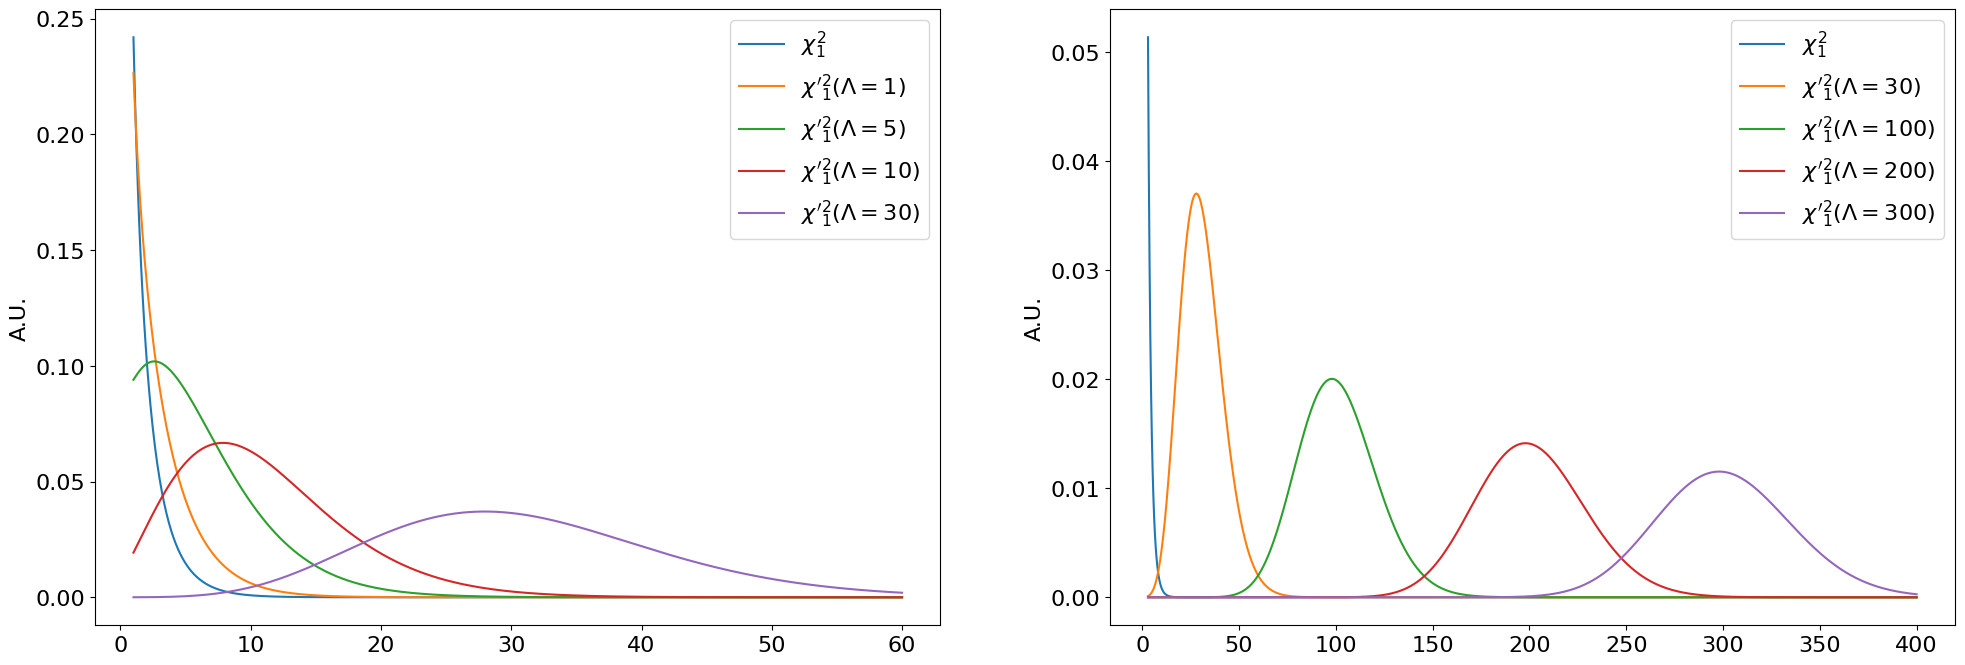

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

Lambdas = [[0, 1, 5, 10, 30], [0, 30, 100, 200, 300]]
xlims = [[1, 60], [3, 400]]

for i in range(2):
    x = np.linspace(*xlims[i], 1001)
    ax = axs[i]
    for l in Lambdas[i]:
        if l == 0:
            ax.plot(x, chi2.pdf(x, 1), label=r"$\chi^2_1$")
        else:
            ax.plot(x, ncx2.pdf(x, 1, l), label=rf"$\chi'^2_1(\Lambda = {l})$")

    ax.set_ylabel("A.U.")
    ax.legend()

plt.show()

```{margin}
More information can be found on e.g. [Wikipedia](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution).
```

We can see that $\chi'^2_k(\Lambda)$ simply shifts towards the right as $\Lambda$ increases (at $\Lambda = 0$ it is a regular central $\chi^2$).
As $\Lambda \rightarrow \infty$, $\chi'^2_k(\Lambda)$ becomes more and more like a normal distribution with mean $\Lambda$.

Hopefully you can convince yourself from here - or try extending the derivation in Eq. {eq}`6plr_taylor` to multiple POIs - of the simple generalization to multiple POIs $\vec\mu$:

```{admonition} Result
:class: tip
$$
p(t_\mu|\mu') \sim \chi'^2_k(\Lambda),
$$ (6chi2multipois)

where the DoF $k$ are equal the number of POIs $\dim\vec\mu$, and 

$$
\Lambda = (\vec\mu - \vec\mu')^T \cdot \tilde{\mathcal I}^{-1}(\vec\mu') \cdot (\vec\mu - \vec\mu'),
$$ (6Lambdamultipois)

where $\tilde{\mathcal I}^{-1}$ is $\mathcal I^{-1}$ restricted only to the components corresponding to the POIs.
```

## Estimating $\sigma_{\hat\mu}^2$

The critical remaining step to understanding the asymptotic distribution of $t_\mu$ is estimating $\sigma_{\hat\mu}^2$ to find the non-centrality parameter $\Lambda$ in Eq. {eq}`6Lambda`.
We'll now go over two methods to this.

### Method 1: Inverting the Fisher information / covariance matrix

```{margin}
More generally, we'd need $\tilde{\mathcal I}^{-1}$ for Eq. {eq}`6Lambdamultipois`.
```

The first method is simply using $\sigma_{\hat\mu} \simeq \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}$ as in Part 5.
Let's see what this looks like for our counting experiment, using the analytic form for $\sigma_{\hat\mu}$ from Eq. {eq}`5asymstd`:

In [5]:
def plot_p_tmu(lambda_fn):
    num_toys = 30000
    s, b = 30, 10
    mus = [0, 1]  # , 1.0, 10.0]
    muprimes = [
        [0, 0.3, 0.6, 1],
        [0, 0.3, 0.6, 1],
    ]

    fig, axs = plt.subplots(1, 3, figsize=(32, 8))
    colours = ["blue", "orange", "green", "red"]

    xmaxs = [40, 80]

    for i, (mu, muprimes) in enumerate(zip(mus, muprimes)):
        axs[i].set_title(rf"Testing $\mu={mu}$ ($s = {s}, b = {b}$)")
        xmax = xmaxs[i]
        for j, muprime in enumerate(muprimes):
            # sample n, m according to our data model (Eq. 1)
            n, m = poisson.rvs(s * muprime + b, size=num_toys), poisson.rvs(b, size=num_toys)
            axs[i].hist(
                t_s(s * mu, n, m),
                np.linspace(0, xmax, 41),
                histtype="step",
                density=True,
                label=rf"$\mu'={muprime}$",
                color=colours[j],
            )

            x = np.linspace(xmax / 160, xmax, 101)

            if mu == muprime:
                axs[i].plot(
                    x, chi2.pdf(x, 1), label=r"$\chi^2_1$", color=colours[j], linestyle="--"
                )
            else:
                l = lambda_fn(mu, muprime, s, b)
                axs[i].plot(
                    x,
                    ncx2.pdf(x, 1, l),
                    label=rf"$\chi'^2_1(\Lambda = {l:.1f})$",
                    color=colours[j],
                    linestyle="--",
                )

        axs[i].legend()
        axs[i].set_xlabel(r"$t_\mu$")
        axs[i].set_ylabel(r"$p(t_\mu|\mu')$")

    i = 2
    sbmumups = [(300, 100, 1, 0), (20, 10, 3, 0), (10, 10, 1, 30)]
    xmax = 600

    for j, (s, b, mu, muprime) in enumerate(sbmumups):
        # sample n, m according to our data model (Eq. 1)
        n, m = poisson.rvs(s * muprime + b, size=num_toys), poisson.rvs(b, size=num_toys)
        axs[i].hist(
            t_s(s * mu, n, m),
            np.linspace(0, xmax, 41),
            histtype="step",
            density=True,
            label=rf"$s = {s}, b = {b}, \mu = {mu}, \mu'={muprime}$",
            color=colours[j],
        )

        x = np.linspace(xmax / 160, xmax, 101)

        if mu == muprime:
            axs[i].plot(x, chi2.pdf(x, 1), label=r"$\chi^2_1$", color=colours[j], linestyle="--")
        else:
            l = lambda_fn(mu, muprime, s, b)
            axs[i].plot(
                x,
                ncx2.pdf(x, 1, l),
                label=rf"$\chi'^2_1(\Lambda = {l:.1f})$",
                color=colours[j],
                linestyle="--",
            )

    axs[i].set_ylim(0, 0.03)
    axs[i].legend()
    axs[i].set_xlabel(r"$t_\mu$")
    axs[i].set_ylabel(r"$p(t_\mu|\mu')$")

    plt.show()

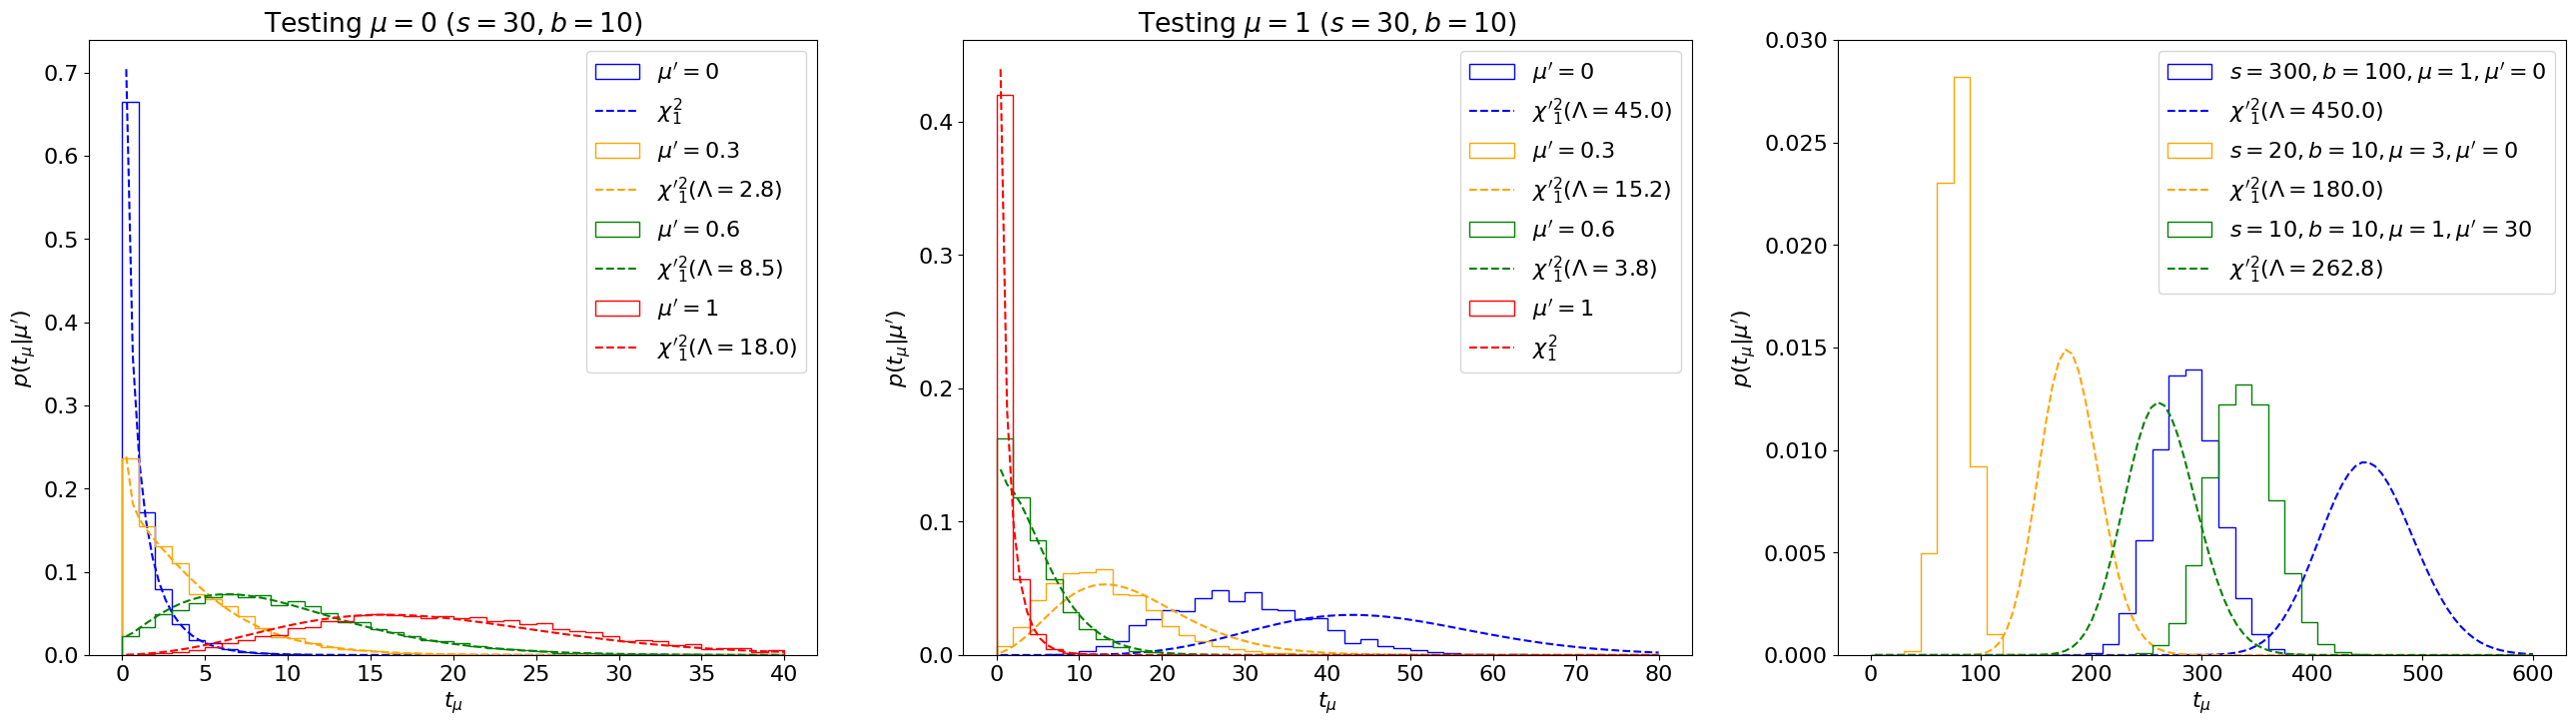

In [6]:
def LambdaFisher(mu, muprime, s, b):
    """
    Non-centrality parameter of the asymptotic non-central chi-squared distribution of p(t_mu),
    estimated using the inverse of the Fisher information matrix.
    """
    return np.power((mu - muprime) / get_asym_std(muprime, s, b), 2)


plot_p_tmu(LambdaFisher)

We can see that this asymptotic approximation agrees well with the true distribution for some range of parameters, but can deviate significantly for others, as highlighted especially in the right plot.

### Interlude on Asimov dataset

While we are able to find the analytic form for $\sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}$ easily for our simple counting experiment, in general it has to be calculated numerically.
As introduced in Part {ref}`5.6 <5numerical_estimation>`, to deal with the expectation value under $\mu', b'$ in Eq. {eq}`6fisher_matrix`, we can make use of the **Asimov dataset**, where the observations $n_A$, $m_A$ are taken to be their expectation values under $\mu', b'$, simplifying the calculation of $\mathcal I$ to Eq. {eq}`5fisher_asimov`.

Explicitly, for our counting experiment (Eq. {eq}`6model`), the Asimov observations are simply

```{margin}
This follows from the expectation value $\mathbb E[x]$ of a Poisson random variable $x \sim \mathrm{Pois}(x; \nu)$ being $\nu$.
```

$$
n_A &= \mathbb E[n] = \mu' s + b' \\
m_A &= \mathbb E[m] = b'.
$$ (6asimov_data)

We'll now consider a second powerful use of the Asimov dataset to estimate $\sigma^2_{\hat\mu}$.

### Method 2: The "Asimov sigma" estimate

Putting together Eqs. {eq}`6mles` and {eq}`6asimov_data`, we can derive a nice property of the Asimov dataset: the MLEs $\hat\mu$, $\hat b$ equal the true values $\mu'$, $b'$:

$$
    \hat b &= m_A = b' \\
    \hat \mu &= \frac{n_A - m_A}{s} = \frac{\mu's + b' - b'}{s} = \mu'.
$$ (6asimov_mles)

Thus, $t_\mu$ evaluated for the Asimov dataset is exactly the non-centrality parameter $\Lambda$ that we are after!

$$
    t_{\mu, A} \simeq \bigg (\frac{\mu-\hat\mu}{\sigma_{\hat\mu}}\bigg)^2 = \bigg (\frac{\mu-\mu'}{\sigma_{\hat\mu}}\bigg)^2 = \Lambda.
$$ (6tmuasimov)

While, not strictly necessary to obtain the asymptotic form for $p(t_\mu|\mu')$, we can also invert this to estimate $\sigma_{\hat\mu}$, as

$$
    \sigma_A \simeq \frac{(\mu-\mu')^2}{t_{\mu, A}},
$$ (6asimov_sigma)

where $\sigma_A$ is called the "Asimov sigma".

We plot below the asymptotic distributions using $\Lambda \simeq t_{\mu, A}$:

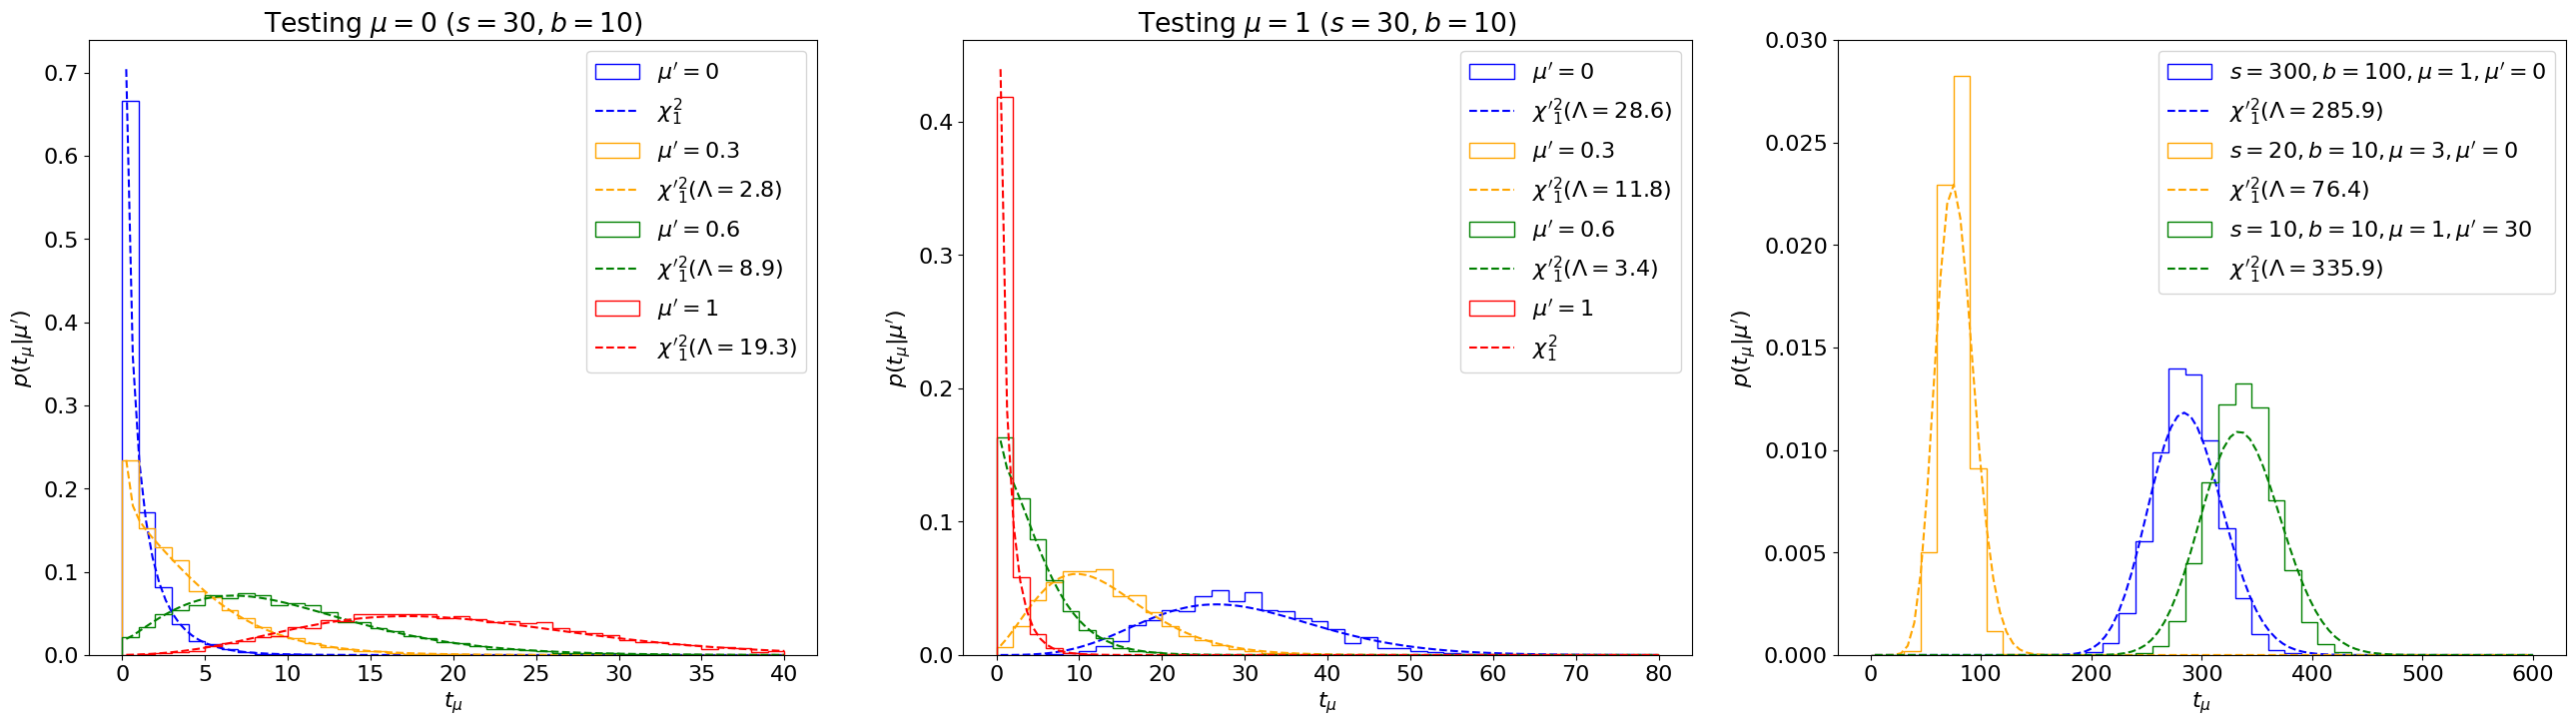

In [7]:
def LambdaA(mu, muprime, s, bprime):
    """
    Non-centrality parameter of the asymptotic non-central chi-squared distribution of p(t_mu),
    estimated using the test statistic for the Asimov dataset n = E[n] = µ's + b', m = E[m] = b'
    """
    return t_s(s * mu, s * muprime + bprime, bprime)


plot_p_tmu(LambdaA)

```{margin}
Reference {cite}`Cowan:2010js` conjectures that this is because the Fisher-information-approach is restricted only to estimating the second-order term of Eq. {eq}`6plr_taylor`, while with $t_{\mu, A}$ we're matching the shape of the likelihood at the minimum which may be able capture some of the higher order terms as well.
```

We see that this estimate matches the sampling distributions very well, even for cases where the covariance-matrix-estimate failed!
Indeed, this is why estimating $\sigma_{\hat\mu} \simeq \sigma_A$ is the standard in LHC analyses, and that is the method we'll employ going forward.


```{admonition} Important
:class: important
Despite the pervasive use of the asymptotic formula at the LHC, it's important to remember that it's an *approximation*, only valid for large statistics.
We can see how it breaks down for $s, b \lesssim 10$ below.
```

In [8]:
def plot_p_tmu_sb(lambda_fn):
    num_toys = 30000
    sbs = [(1, 1), (3, 1), (10, 1), (10, 3)]
    mus = [0, 1]
    muprimes = [1, 0]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    colours = ["blue", "orange", "green", "red"]

    xmaxs = [30, 30]

    for i, (mu, muprime) in enumerate(zip(mus, muprimes)):
        axs[i].set_title(rf"Testing $\mu={mu}$ under $\mu' = {muprime}$")
        xmax = xmaxs[i]
        for j, (s, b) in enumerate(sbs):
            # sample n, m according to our data model (Eq. 1)
            n, m = poisson.rvs(s * muprime + b, size=num_toys), poisson.rvs(b, size=num_toys)
            axs[i].hist(
                t_s(s * mu, n, m),
                np.linspace(0, xmax, 41),
                histtype="step",
                density=True,
                label=rf"$s={s}, b={b}$",
                color=colours[j],
            )

            x = np.linspace(xmax / 160, xmax, 101)

            if mu == muprime:
                axs[i].plot(
                    x, chi2.pdf(x, 1), label=r"$\chi^2_1$", color=colours[j], linestyle="--"
                )
            else:
                l = lambda_fn(mu, muprime, s, b)
                axs[i].plot(
                    x,
                    ncx2.pdf(x, 1, l),
                    label=rf"$\chi'^2_1(\Lambda = {l:.1f})$",
                    color=colours[j],
                    linestyle="--",
                )

        axs[i].legend()
        axs[i].set_xlabel(r"$t_\mu$")
        axs[i].set_ylabel(r"$p(t_\mu|\mu')$")

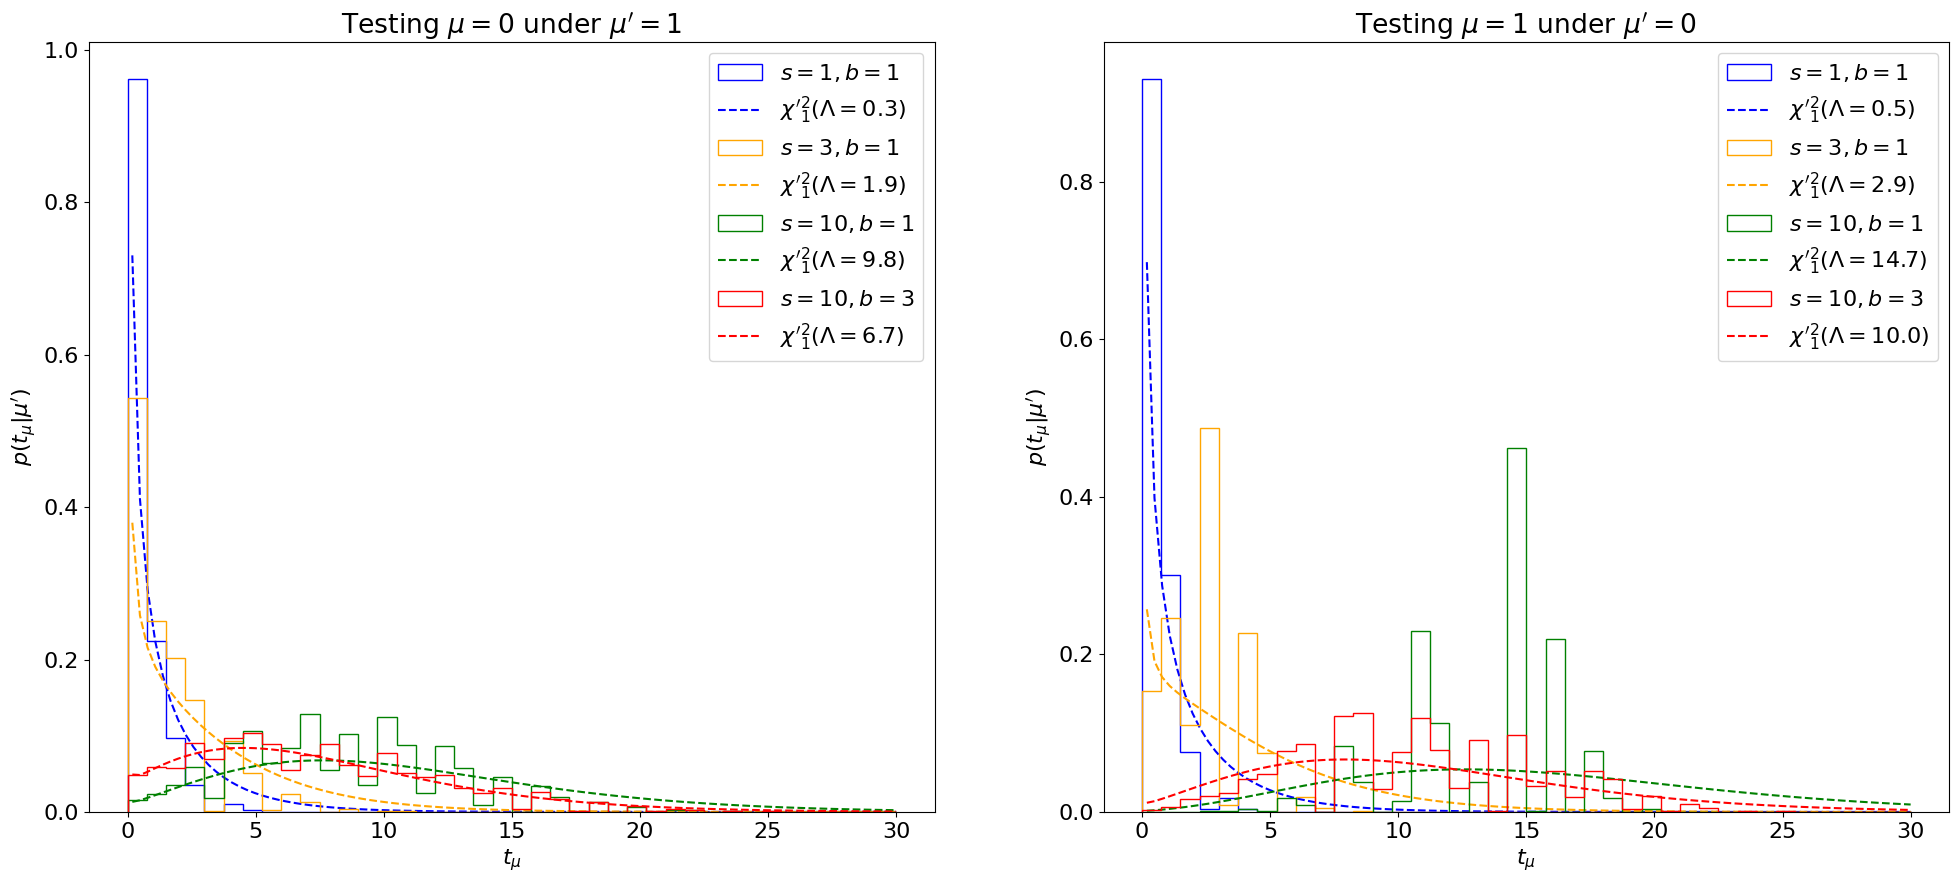

In [9]:
plot_p_tmu_sb(LambdaA)

## The PDF and CDF

The probability distribution function (PDF) for a $\chi'^2_k(\Lambda)$ distribution can be found on e.g. [Wikipedia](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution) as being (for $k=1$ here):

$$
    p(t_\mu|\mu') \simeq \chi'^2_1(\Lambda) = \frac{1}{2\sqrt{t_\mu}}\big(\varphi(\sqrt{t_\mu} - \sqrt\Lambda) + \varphi(\sqrt{t_\mu} + \sqrt\Lambda)\big),
$$ (6ptmu_pdf)

where $\varphi$ is the PDF of a standard normal distribution.

For $\mu = \mu' \Rightarrow \Lambda = 0$, this simplifies to:

$$
    p(t_\mu|\mu) \simeq \chi^2 = \frac{1}{\sqrt{t_\mu}}\varphi(\sqrt{t_\mu}).
$$ (6ptmu_pdf_special)

The cumulative distribution function (CDF), again from [Wikipedia](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution) (and $k=1$) is:

$$
    F(t_\mu|\mu') \simeq \Phi(\sqrt{t_\mu} - \sqrt\Lambda) + \Phi(\sqrt{t_\mu} + \sqrt\Lambda) - 1,
$$ (6ptmu_cdf)

where $\Phi$ is the CDF of the standard normal distribution.

For $\mu = \mu' \Rightarrow \Lambda = 0$, again this simplifies to:

$$
    F(t_\mu|\mu) \simeq 2\Phi(\sqrt{t_\mu}) - 1.
$$ (6ptmu_cdf_special)

From Eq. {eq}`6pvalue`, we know the $p$-value $p_\mu$ of the observed $t_\mu^\mathrm{obs}$ under a signal hypothesis of $H_\mu$ is

$$
    p_\mu = 1 - F(t_\mu^\mathrm{obs}|\mu) = 2(1 - \Phi(\sqrt{t_\mu^\mathrm{obs}})),
$$ (6pmu_asym)

with an associated significance

$$
    Z = \Phi^{-1}(1-p_\mu) = \Phi^{-1}(2\Phi(\sqrt{t_\mu^\mathrm{obs}} - 1)
$$ (6Z_asym)

## Application to hypothesis testing

Let's see how well this approximation with toy-based $p$-values we were finding in Part {ref}`2.4 <2pvalues>`.
For the same counting experiment example, where we expect $s = 10$ and observe $n_\mathrm{obs} = 20$, $m_\mathrm{obs} = 5$, we found the $p$-value for testing the $\mu = 1$ hypothesis $p_{\mu = 1} = 0.3$ (and the associated significance $Z = 0.52$).

Using the asymptotic approximation:

```{margin}
Note that we're using $t_\mu$ here, not the alternative test statistic $\tilde{t_\mu}$; however, in this case since $\hat\mu > 0$ , they are equivalent.
Asymptotic formulae for the $\tilde{t}_\mu$ and $\tilde{q}_\mu$ test statistics will be discussed in the next part.
```

In [10]:
def p_mu_asym(mu, s, n, m):
    """The p-value of the observations n and m under the mu signal strength hypothesis using the asymptotic approximation"""
    t_obs = t_s(mu * s, n, m)
    return 2 * (1 - norm.cdf(np.sqrt(t_obs)))


p_value_res = p_mu_asym(1, 10, 20, 5)
Z = norm.ppf(1 - p_value_res)
display(Latex(f"$p_\mu = {p_value_res:.2f}, Z = {Z:.2f}$"))

<IPython.core.display.Latex object>

We see that it agrees exactly! We can check more generally, varying $s, \mu, n_\mathrm{obs}, m_\mathrm{obs}$:

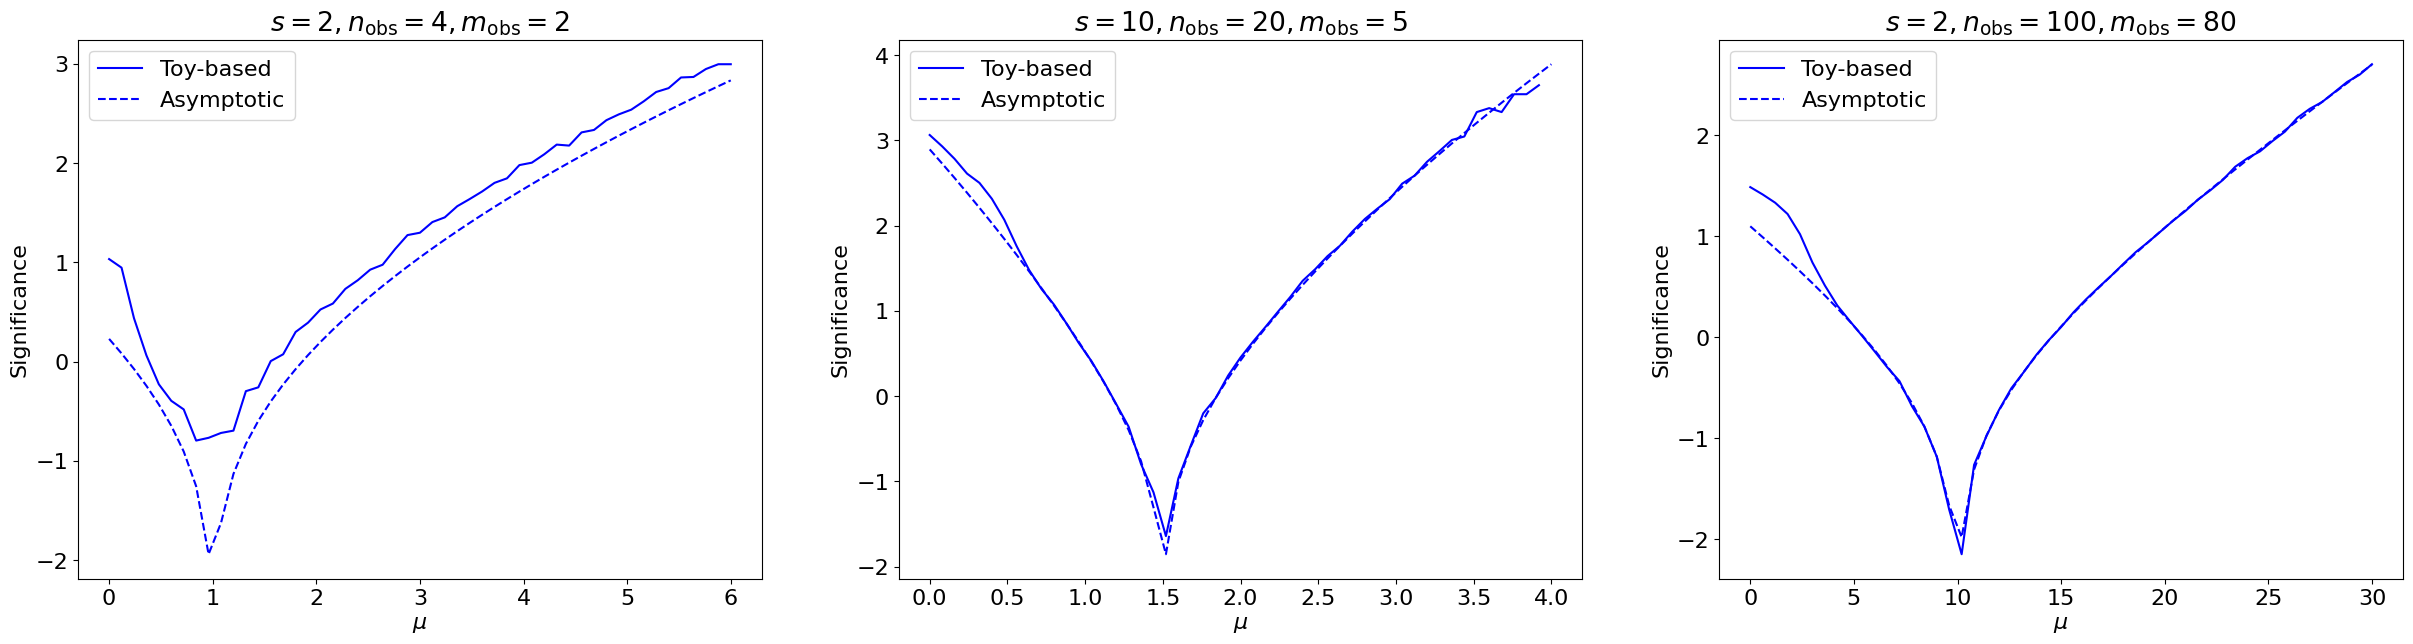

In [13]:
def plot_p_tmu_sb():
    num_toys = 30000
    nms = [(4, 2, 2), (20, 5, 10), (100, 80, 2)]
    muranges = [(0, 6), (0, 4), (0, 30)]
    mus = [1]

    fig, axs = plt.subplots(1, len(nms), figsize=(len(nms) * 10, 7))
    colours = ["blue", "orange", "green", "red"]

    for i, (n, m, s) in enumerate(nms):
        murange = muranges[i]
        axs[i].set_title(rf"$s = {s}, n_\mathrm{{obs}}={n}, m_\mathrm{{obs}}={m}$")
        for j, mu in enumerate(mus):
            x = np.linspace(*murange, 51)
            signs_toys = []  # significances using toys
            signs_asym = []  # significances using asymptotic approximation
            for mu in x:
                # getting significance using toy-based p-value
                signs_toys.append(get_Z(get_ps_val(mu * s, n, m, num_toys)[0]))
                # getting significance using new asymptotic form for p-value
                signs_asym.append(get_Z(p_mu_asym(mu, s, n, m)))

            axs[i].plot(x, signs_toys, label=rf"Toy-based", color=colours[j])
            axs[i].plot(x, signs_asym, label=rf"Asymptotic", color=colours[j], linestyle="--")

        axs[i].legend()
        axs[i].set_ylabel("Significance")
        axs[i].set_xlabel(r"$\mu$")
        # axs[i].set_ylim(-2, 4)

    plt.show()


plot_p_tmu_sb()

We observe generally strong agreement, except for low $n, m$ where, as expected, the asymptotic approximation breaks down.

## Summary

We have been able to find the asymptotic form for the profile-likelihood-ratio test statistic $t_\mu \simeq \frac{(\mu-\hat\mu)^2}{\sigma_{\hat\mu}^2}$, which is distributed as a *non-central chi-squared* ($\chi'^2_k(\Lambda)$) distribution.
We discussed two methods for finding the non-centrality parameter $\Lambda$, out of which the Asimov sigma $\sigma_A$ estimation generally performed better.
Finally the asymptotic formulae were applied to simple examples of hypothesis testing to check the agreement with toy-based significances.
In the next part, we will discuss asymptotic formulae for the alternative test statistics for positive signals $\tilde{t}_\mu$ and upper-limit-setting $\tilde{q}_\mu$.